In [1]:
import pandas as pd
import os
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


### 1. Subset the feature table

In [3]:
data = pd.read_csv('sardana-097/HACKATHON/csv/WD-76845-097.csv')
truth = pd.read_csv('sardana-097/HACKATHON/csv/truth.csv')

noisy_ids = truth['CellID'][truth['class_label'] != 1]
clean_ids = truth['CellID'][truth['class_label'] == 1]

clean_ids_subset = clean_ids.sample(n=len(noisy_ids), random_state=0)

In [4]:
total_ids_subset = pd.concat((noisy_ids, clean_ids_subset))

final = data[data['CellID'].isin(total_ids_subset)]
final.to_csv('./feature_table_subset.csv', index=False)
len(total_ids_subset)

101748

### 2. Generate training and test data

In [5]:
feature_table_subset = pd.read_csv('./feature_table_subset.csv')
feature_table_subset.head()


,CellID,Hoechst0,AF488,AF555,AF647,Hoechst1,A488,A555,A647,Hoechst2,...,Y_centroid,column_centroid,row_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
0,8,368.628319,934.362832,380.849558,675.415929,348.194690,864.008850,372.761062,760.769912,359.982301,...,846.893805,20622.858407,846.893805,113,15.712891,9.480411,0.797475,0.941667,0.553922,-0.224525
1,54,339.355140,842.093458,345.915888,671.065421,313.551402,776.140187,357.542056,737.177570,331.429907,...,1240.439252,18021.271028,1240.439252,107,18.849453,7.630867,0.914391,0.955357,0.419608,-0.851222
2,62,14756.867133,6850.706294,2434.111888,973.027972,48019.160839,2320.013986,937.538462,1344.489510,41201.111888,...,1244.398601,9404.461538,1244.398601,143,17.570921,10.601379,0.797478,0.986207,0.722222,-1.212504
3,127,367.652778,899.824074,360.078704,680.750000,348.027778,827.837963,370.787037,744.620370,355.083333,...,1320.407407,19109.277778,1320.407407,216,20.782641,13.268136,0.769685,0.964286,0.720000,-0.352952
4,140,17104.951807,7501.767068,2608.425703,993.742972,41881.819277,2179.935743,833.072289,1082.522088,33713.783133,...,1333.722892,8086.385542,1333.722892,249,24.103029,13.190576,0.836964,0.972656,0.798077,1.485339


In [6]:
truth = pd.read_csv('sardana-097/HACKATHON/csv/truth.csv')
truth['class_label'].value_counts()

class_label
1    1191882
5      26439
2      22282
4       1337
3        647
6        169
Name: count, dtype: int64

In [7]:
marker_list = ['Hoechst0', 'anti_CD3', 'anti_CD45RO', 'Keratin_570', 'aSMA_660', 'CD4_488', 'CD45_PE', 
               'PD1_647', 'CD20_488', 'CD68_555', 'CD8a_660', 'CD163_488', 'FOXP3_570', 'PDL1_647', 
               'Ecad_488', 'Vimentin_555', 'CDX2_647', 'LaminABC_488', 'Desmin_555', 'CD31_647', 
               'PCNA_488', 'CollagenIV_647', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 
               'Solidity', 'Extent', 'Orientation']

marker_list += ['class_label','CellID']
dataset = pd.merge(feature_table_subset, truth, on='CellID', how='inner')
dataset = dataset[marker_list]

In [8]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    dataset.loc[:,dataset.columns!='class_label'], 
    dataset['class_label'], 
    test_size=0.3, random_state=0, 
    stratify=dataset['class_label'])

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.loc[:,X_train.columns!='CellID'])
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns = marker_list[:-2], 
                              index = X_train['CellID'])
X_train_scaled['CellID'] = X_train_scaled.index
X_train_scaled = X_train_scaled.reset_index(drop=True)
# Test data comes from same distribution as training data
X_test_scaled = scaler.transform(X_test.loc[:,X_test.columns!='CellID'])
X_test_scaled = pd.DataFrame(X_test_scaled, 
                             columns = marker_list[:-2], 
                             index = X_test['CellID'])
X_test_scaled['CellID'] = X_test_scaled.index
X_test_scaled = X_test_scaled.reset_index(drop=True)

In [10]:
output_path = './preprocessed_data'
X_train_scaled.to_csv(os.path.join(output_path,'X_train_scaled.csv'),index=False)
X_test_scaled.to_csv(os.path.join(output_path,'X_test_scaled.csv'),index=False)
y_train.to_csv(os.path.join(output_path,'y_train.csv'),index=False)
y_test.to_csv(os.path.join(output_path,'y_test.csv'),index=False)

### 3. Train model and evaluate on test set

In [11]:
def artifact_detection(clf, clf_name, X_train, y_train, X_test, y_test, out_path):
    print(os.path.join(out_path,f'{clf_name}_scores.csv'))
    cellids = X_test['CellID']
    if ('CellID' in X_train.columns):
        X_train = X_train.loc[:,X_train.columns!='CellID']
    if ('CellID' in X_test.columns):
        X_test = X_test.loc[:,X_test.columns!='CellID']
    

    clf = clf.fit(X_train.values, y_train['class_label'])
    clf_score = clf.score(X_test.values, y_test['class_label'])
    print(f"[Model score = {clf_score}]")
    # Generate Scores
    clf_probs = clf.predict_proba(X_test.values)
    clf_probs = pd.DataFrame(clf_probs,columns=['1','2','3','4','5','6'])
    clf_probs['CellID'] = cellids
    clf_probs.to_csv(os.path.join(out_path,f'{clf_name}_scores.csv'),index=False)
    # Plot ROC
    # roc_df(clf_probs, y_test)

    # Generate Calls
    clf_probs['class_label'] = clf_probs.loc[:,clf_probs.columns!='CellID'].idxmax(axis='columns')
    clf_probs.drop(columns=['1','2','3','4','5','6'], inplace=True)
    clf_probs.to_csv(os.path.join(out_path,f'{clf_name}_calls.csv'),index=False)



In [12]:
data_path = './preprocessed_data/'
X_tr = pd.read_csv(os.path.join(data_path,'X_train_scaled.csv'))
X_ts = pd.read_csv(os.path.join(data_path,'X_test_scaled.csv'))
y_tr = pd.read_csv(os.path.join(data_path,'y_train.csv'))
y_ts = pd.read_csv(os.path.join(data_path,'y_test.csv'))
X_tr.shape, X_ts.shape

((71223, 30), (30525, 30))

In [14]:
mlp_clf = MLPClassifier(hidden_layer_sizes= (100, 50, 25, 12, 6), early_stopping=True, validation_fraction=0.2, 
                        learning_rate='adaptive', max_iter=500)

artifact_detection(mlp_clf,'mlp',
                  X_tr, y_tr, X_ts, y_ts,
                  './feature_morph')

./feature_morph/mlp_scores.csv
[Model score = 0.9295004095004095]


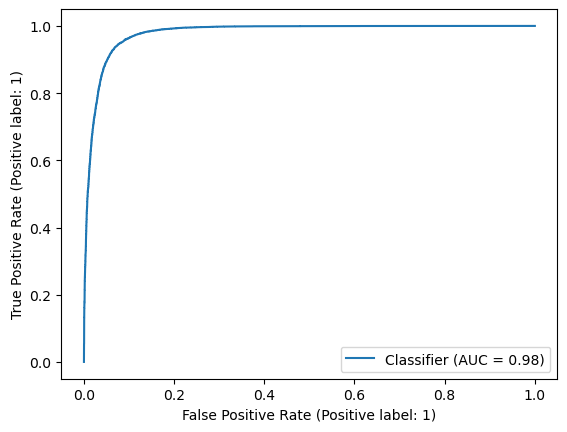

In [15]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

y_score_ts = pd.read_csv('./feature_morph/mlp_scores.csv')['1']
label_binarizer = LabelBinarizer().fit(y_tr['class_label'])
y_ts_onehot = label_binarizer.transform(y_ts['class_label'])

roc = RocCurveDisplay.from_predictions(y_ts_onehot[:,0], y_score_ts)

### 4. Assemble and save model

In [16]:
from sklearn.pipeline import Pipeline
import pickle as pkl

pipe = Pipeline([('scaler', scaler),
                 ('classifier', mlp_clf)])

with open('./pretrained_model.pkl', 'wb') as f:
    pkl.dump(pipe, f)

In [17]:
import pickle as pkl

with open('./pretrained_model.pkl', 'rb') as f:
    pipe = pkl.load(f)

In [22]:
import numpy as np
res = pipe.predict(X_test.loc[:,X_test.columns!='CellID'])
unique, counts = np.unique(res, return_counts=True)
print(dict(zip(unique, counts)))

{1: 15569, 2: 6455, 3: 168, 4: 347, 5: 7943, 6: 43}


In [24]:
X_test.loc[:,X_test.columns!='CellID'].shape

(30525, 29)